In [1]:
from os import environ
from getpass import getpass

def _set_env(var: str):
    if not environ.get(var):
        environ[var] = getpass(f"{var}: ")

_set_env("COHERE_API_KEY")

In [2]:
from langchain_cohere import ChatCohere
llm = ChatCohere(
    model="command-a-03-2025"
)

In [3]:
from __future__ import annotations

from typing import Optional, Literal, List
from typing_extensions import TypedDict, Annotated
from pydantic import BaseModel, Field

Beat = Literal["A", "B", "C", "D", "E"]

class UserInput(BaseModel):
    scholarship_name: str
    program_type: Literal["Undergrad", "Graduate","Community Leadership"]
    goal_one_liner: str
    resume_points: list[str]


class PiiSpan(BaseModel):
    start: int
    end: int
    pii_type: str
    confidence: Optional[float] = None


class BeatPlanItem(BaseModel):
    beat: Beat
    missing: list[str]
    guidance: Optional[str] = None


class QuestionObject(BaseModel):
    beat: Beat
    question: str
    intent: str
    
class BeatPlanOut(BaseModel):
    items: list[BeatPlanItem]

class QuestionsOut(BaseModel):
    items: list[QuestionObject]

class ValidationReport(BaseModel):
    ok: bool
    errors: list[str] = Field(default_factory=list)
    warnings: list[str] = Field(default_factory=list)
    repairs_applied: list[str] = Field(default_factory=list)


def merge_questions_by_beat(left: dict[Beat, List[QuestionObject]], right: dict[Beat, List[QuestionObject]]):
    out = dict(left or {})
    for beat, qs in (right or {}).items():
        out.setdefault(beat, []).extend(qs)
    return out

class PipelineState(TypedDict, total=False):
    # Inputs
    user_input: UserInput

    # Governance front gate
    canonical_input: str
    pii_spans: list[PiiSpan]
    redacted_input: str

    # Planning
    beat_plan: list[BeatPlanItem]

    # Map outputs (per beat)
    
    questions_by_beat: Annotated[dict[Beat, list[QuestionObject]], merge_questions_by_beat]

    # Reduce outputs
    final_questions_by_beat: dict[Beat, list[QuestionObject]]
    
    # Validation outputs
    failed_beats: list[Beat]
    failed_reasons: dict[Beat, list[str]]


    # Reliability / repair
    validation_report: ValidationReport
    attempt_count: int

    regen_request: list[Beat]

In [4]:
from presidio_analyzer import AnalyzerEngine
from presidio_anonymizer import AnonymizerEngine
from presidio_anonymizer.entities import OperatorConfig
from typing import Any

def _build_canonical_input(user_input: UserInput) -> str:
    """
    A helper to combine all the inputs together."""
    bullets = "\n".join(f"- {b}" for b in user_input.resume_points)
    return (
        f"Scholarship: {user_input.scholarship_name}\n"
        f"Program type: {user_input.program_type}\n"
        f"Goal: {user_input.goal_one_liner}\n"
        f"Resume points:\n{bullets}\n"
    )

def make_redactor_node(
    *,
    language: str = "en",
    entities: List[str] | None = None,
    default_operator: str = "replace",
) :
    """
    A presidio wrapper to create the redactor node.
    """
    analyzer = AnalyzerEngine()
    anonymizer = AnonymizerEngine()
    entities = entities or ["PERSON", "PHONE_NUMBER", "EMAIL_ADDRESS", "LOCATION", "CREDIT_CARD", "URL"]

    # Replace PII with its entity type,<EMAIL_ADDRESS>.
    # (Presidio supports different operators; replace/mask/redact, etc.) :contentReference[oaicite:4]{index=4}
    operators: dict[str, OperatorConfig] = {
        "DEFAULT": OperatorConfig(default_operator, {"new_value": "<REDACTED>"}),
        "EMAIL_ADDRESS": OperatorConfig("replace", {"new_value": "<EMAIL>"}),
        "PHONE_NUMBER": OperatorConfig("replace", {"new_value": "<PHONE>"}),
        "PERSON": OperatorConfig("replace", {"new_value": "<NAME>"}),
        "LOCATION": OperatorConfig("replace", {"new_value": "<LOCATION>"}),
        "URL": OperatorConfig("replace", {"new_value": "<URL>"}),
    }

    def redactor_node(state: "PipelineState") -> dict[str, Any]:
        user_input = state["user_input"]
        canonical = _build_canonical_input(user_input)

        results = analyzer.analyze(
            text=canonical,
            language=language,
            entities=entities,
        )

        pii_spans = [
            PiiSpan(
                start=r.start,
                end=r.end,
                pii_type=r.entity_type,
                confidence=float(r.score) if r.score is not None else None,
            )
            for r in results
        ]

        redacted = anonymizer.anonymize(
            text=canonical,
            analyzer_results=results,
            operators=operators,
        ).text

        return {
            "canonical_input": canonical,
            "pii_spans": pii_spans,
            "redacted_input": redacted,
            "attempt_count": state.get("attempt_count", 0),
            "questions_by_beat": state.get("questions_by_beat", {}),
        }

    return redactor_node


In [5]:
from typing import Literal
from langgraph.types import Command, Send
from langgraph.graph import START, END, StateGraph
from IPython.display import Image, display
from textwrap import dedent

def _beat_defs() -> str:
    return dedent("""\
    Beats:
    A: Purpose & Fit
    B: Excellence / Proof
    C: Impact
    D: Leadership & Character
    E: Reflection & Growth
    """)

def beat_planner_messages(redacted_input: str):
    system = dedent("""\
    You are a beat planner for an SOP question generator.
    Return structured data only. No prose.
    """)

    rules = dedent("""\
    Create a plan for beats A–E.

    For each beat output:
    - beat: one of A,B,C,D,E
    - missing: 2–4 short, specific missing details needed to write that beat,
      grounded in the redacted input (reference the section name when possible).
    - guidance: one actionable hint (<= 20 words).
    - anchors: 2–4 exact phrases copied verbatim from the redacted input (each <= 6 words)
      that are relevant to this beat.

    Constraints:
    - Include A,B,C,D,E exactly once.
    - If the input lacks anchors for a beat, set anchors=[] and put the needed specifics in missing.
    """)

    user_ctx = dedent(f"""\
    {_beat_defs()}
    Redacted canonical input (source of truth):
    {redacted_input}

    Return a beat plan.
    """)

    return [
        {"role": "system", "content": system},
        {"role": "user", "content": rules + "\n\n" + user_ctx},
    ]

from textwrap import dedent

def question_generator_messages(task, redacted_input: str):
    system = dedent("""\
    You generate tailored SOP questions.
    Return structured data only. No prose.
    """)

    regen_mode = bool(task.guidance and "Regenerate questions" in task.guidance)

    base_rules = dedent("""\
    Generate exactly 2 questions for the given beat.

    Output format:
    {
      "beat": "A|B|C|D|E",
      "questions": [
        {"q": "...?", "intent": "...", "anchor_used": "..."},
        {"q": "...?", "intent": "...", "anchor_used": "..."}
      ]
    }

    Constraints:
    - Structured data only.
    - Questions only: each q must be a single line ending with '?'.
    - Do NOT include any PII or placeholders like <NAME>, <EMAIL>, <PHONE>, [ORG_1].
    - intent must be <= 12 words and describe what the question tests.
    - beat must equal the provided beat.
    - Keep wording concise.
    - The two questions must be meaningfully different:
      * Q1: narrative/decision/tradeoff
      * Q2: evidence/validation/comparison/feedback signal
    """)

    grounding_rules = dedent("""\
    Grounding rules:
    - Do NOT introduce specific names, organizations, dates, locations, or numbers
      unless they appear verbatim in the provided redacted input.
    - If a specific detail is missing, ask for it instead of assuming it.
    """)

    anti_generic_rules = dedent("""\
    Anti-generic rules:
    - Each question must be anchored: it must include an exact short phrase from task.anchors
      (verbatim) OR explicitly reference a specific section/item from the redacted input
      (e.g., “Experience Inventory #2”).
    - Avoid generic openers like “Tell me about a time…” unless tied to a named anchor.
    - No filler: every question must point to a concrete story, decision, or evidence.
    """)

    regen_rules = dedent("""\
    Regeneration rule:
    - Previous output failed validation. Make questions more grounded and less assumption-heavy.
    - Prefer asking for missing details rather than stating facts.
    """) if regen_mode else ""

    beat_ctx = dedent(f"""\
    Beat: {task.beat}
    Missing: {task.missing}
    Guidance: {task.guidance}
    Anchors: {getattr(task, "anchors", [])}
    """)

    user = dedent(f"""\
    {_beat_defs()}
    {beat_ctx}

    Redacted input (source of truth):
    {redacted_input}
    """)

    return [
        {"role": "system", "content": system},
        {"role": "user", "content": base_rules + grounding_rules + anti_generic_rules + regen_rules + "\n\n" + user},
    ]

def question_generator_messages(task, redacted_input: str):
    system = dedent("""\
    You generate tailored SOP questions.
    Return structured data only. No prose.
    """)

    regen_mode = bool(task.guidance and "Regenerate questions" in task.guidance)

    base_rules = dedent("""\
    Generate exactly 2 questions for the given beat.

    Output format:
    {
      "beat": "A|B|C|D|E",
      "questions": [
        {"q": "...?", "intent": "...", "anchor_used": "..."},
        {"q": "...?", "intent": "...", "anchor_used": "..."}
      ]
    }

    Constraints:
    - Structured data only.
    - Questions only: each q must be a single line ending with '?'.
    - Do NOT include any PII or placeholders like <NAME>, <EMAIL>, <PHONE>, [ORG_1].
    - intent must be <= 12 words and describe what the question tests.
    - beat must equal the provided beat.
    - Keep wording concise.
    - The two questions must be meaningfully different:
      * Q1: narrative/decision/tradeoff
      * Q2: evidence/validation/comparison/feedback signal
    """)

    grounding_rules = dedent("""\
    Grounding rules:
    - Do NOT introduce specific names, organizations, dates, locations, or numbers
      unless they appear verbatim in the provided redacted input.
    - If a specific detail is missing, ask for it instead of assuming it.
    """)

    anti_generic_rules = dedent("""\
    Anti-generic rules:
    - Each question must be anchored: it must include an exact short phrase from task.anchors
      (verbatim) OR explicitly reference a specific section/item from the redacted input
      (e.g., “Experience Inventory #2”).
    - Avoid generic openers like “Tell me about a time…” unless tied to a named anchor.
    - No filler: every question must point to a concrete story, decision, or evidence.
    """)

    regen_rules = dedent("""\
    Regeneration rule:
    - Previous output failed validation. Make questions more grounded and less assumption-heavy.
    - Prefer asking for missing details rather than stating facts.
    """) if regen_mode else ""

    beat_ctx = dedent(f"""\
    Beat: {task.beat}
    Missing: {task.missing}
    Guidance: {task.guidance}
    Anchors: {getattr(task, "anchors", [])}
    """)

    user = dedent(f"""\
    {_beat_defs()}
    {beat_ctx}

    Redacted input (source of truth):
    {redacted_input}
    """)

    return [
        {"role": "system", "content": system},
        {"role": "user", "content": base_rules + grounding_rules + anti_generic_rules + regen_rules + "\n\n" + user},
    ]

In [6]:
import re
from typing import Dict, List, Tuple


ALL_BEATS: list[Beat] = ["A", "B", "C", "D", "E"]

# At most two questions per beat for demo consistency
PLANNER_TEMP=0.5
MAX_PER_BEAT = 2


GENERATOR_TEMP=0.7
# Upper bound of regenerations
MAX_ATTEMPT = 3

def _norm_q(s: str) -> str:
    # Normalize for dedupe: lowercase, collapse whitespace, strip punctuation-ish
    s = s.strip().lower()
    s = re.sub(r"\s+", " ", s)
    s = re.sub(r"[“”\"'`]", "", s)
    s = re.sub(r"\s*\?\s*$", "?", s)  # unify question mark ending
    return s

# Enforcing grounding constraints and regenerating only the failing beat / quesitons



In [8]:
"""
Core validation logic that checks:

1. Coverage (A-E present)
2. Question formatting (single-line, ends with ?)
3. Intent length sanity
4. No PII placeholders
5. Ungrounded numbers (any numbers in question must appear in the redacted input)
6. Ungrounded name entities using spaCy NER. It must apear in redacted_input.
e.g. Institution name, research subdomains, research roles...
"""

import re
try:
    from spacy import load
    NER_MODEL = load("en_core_web_sm", disable=["parser", "lemmatizer"])
except Exception:
    NER_MODEL = None
    
_num_re = re.compile(r"\b\d+(\.\d+)?%?\b")
_placeholder_re = re.compile(r"<(NAME|EMAIL|PHONE|LOCATION|URL|REDACTED)>", re.IGNORECASE)

def _norm(s: str) -> str:
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

def _ungrounded_numbers(question: str, source_norm: str) -> list[str]:
    nums = {m.group(0) for m in _num_re.finditer(question)}
    missing = []
    for n in nums:
        n_norm = _norm(n)
        if n_norm not in source_norm:
            missing.append(n)
    return sorted(set(missing))

def _ungrounded_entities(question: str, source_text: str, source_norm: str) -> list[str]:
    if NER_MODEL is not None:
        doc = NER_MODEL(question)
        suspects = []
        for ent in doc.ents:
            if ent.label_ in {"PERSON", "ORG", "GPE", "LOC", "DATE", "TIME", "MONEY", "PERCENT", "EVENT", "PRODUCT"}:
                ent_text = ent.text.strip()
                if len(ent_text) < 2:
                    continue
                # Compare normalized versions
                if _norm(ent_text) not in source_norm:
                    suspects.append(ent_text)
        return sorted(set(suspects))

    # Deterministic fallback.
    props = re.findall(r"\b[A-Z][a-zA-Z]+\b", question)
    suspects = []
    for p in props:
        if _norm(p) not in source_norm:
            suspects.append(p)
    return sorted(set(suspects))

def _validate_question_text(q: str) -> list[str]:
    reasons = []
    if not q.strip():
        reasons.append("Empty question text.")
        return reasons
    if "\n" in q.strip():
        reasons.append("Question must be single-line.")
    if not q.strip().endswith("?"):
        reasons.append("Questions must end with '?'.")
    if q.strip().startswith(("1)", "2)", "-", "*")):
        reasons.append("Looks like a list item, not a standalone question.")
    if _placeholder_re.search(q):
        reasons.append("Question references redaction placeholders (e.g., <NAME>).")
    return reasons



In [9]:

def beat_planner_node(state: PipelineState) -> Command[Literal["question_generator"]]:
    """
    Produces a list of beat plan item and sends a map task.
    """
    
    redacted_input = state["redacted_input"]
    
    planner = llm.bind(temperature=PLANNER_TEMP).with_structured_output(BeatPlanOut)
    out: BeatPlanOut = planner.invoke(beat_planner_messages(redacted_input))

    beat_plan = out.items

    # Hard enforcement: A–E exactly once
    beats = [b.beat for b in beat_plan]
    if sorted(beats) != ["A", "B", "C", "D", "E"]:
        raise ValueError(f"BeatPlanner must output A–E exactly once. Got: {beats}")

    sends = [
        Send("question_generator", {
            "beat_task": item.model_dump(),
            "redacted_input": redacted_input,
        })
        for item in beat_plan
    ]

    return Command(update={"beat_plan": beat_plan}, goto=sends)


def question_generator_node(task: BeatPlanItem, redacted_input: str) -> list[QuestionObject]:
    """
    StateGraph node to generate questions.
    """ 
    generator = llm.bind(temperature=GENERATOR_TEMP).with_structured_output(QuestionsOut)
    out = generator.invoke(question_generator_messages(task, redacted_input))
    return out.items

def question_generator_worker(worker_state: dict[str, Any]) -> dict[str, Any]:
    """
    Generate questions per beat.
    """
    
    if "beat_task" not in worker_state:
        raise KeyError(
            f"question_generator got keys: {list(worker_state.keys())}"
            f"Payload preview: {str(worker_state)}"
        )

    task = BeatPlanItem.model_validate(worker_state["beat_task"])
    redacted_input = worker_state["redacted_input"]

    questions = question_generator_node(task, redacted_input)

    return {"questions_by_beat": {task.beat: questions}}


def assembler_node(state: PipelineState) -> dict:
    """
    Deterministic "reduce": merge + dedupe + trim.
    Returns {"final_questions_by_beat": dict[Beat, list[QuestionObject]]}
    """
    questions_by_beat: dict[Beat, List[QuestionObject]] = state.get("questions_by_beat", {}) or {}

    # Ensure all beats exist
    merged: dict[Beat, List[QuestionObject]] = {b: [] for b in ALL_BEATS}
    for beat, qs in questions_by_beat.items():
        if beat in merged and qs:
            merged[beat].extend(qs)

    seen: set[str] = set()
    final_by_beat: dict[Beat, List[QuestionObject]] = {b: [] for b in ALL_BEATS}

    for beat in ALL_BEATS:
        for q in merged[beat]:
            if not q or not q.question:
                continue
            key = _norm_q(q.question)
            if key in seen:
                continue
            seen.add(key)
            final_by_beat[beat].append(q)

        if len(final_by_beat[beat]) > MAX_PER_BEAT:
            final_by_beat[beat] = final_by_beat[beat][:MAX_PER_BEAT]

    return {"final_questions_by_beat": final_by_beat}


In [10]:
def clear_failed_beats_questions(
    questions_by_beat: dict[Beat, list[QuestionObject]],
    failed_beats: List[Beat]
) -> dict[Beat, list[QuestionObject]]:
    qb = dict(questions_by_beat or {})
    for b in failed_beats:
        qb[b] = []
    return qb

def regenerate_questions(failed_beats: list[str], 
                         plan_map: dict[Beat, BeatPlanItem],
                         redacted_input: str) -> list[Send]:
    sends = []
    for b in failed_beats:
        bp = plan_map.get(b) or BeatPlanItem(beat=b, missing=[], guidance=None)

        # Strengthen guidance for regen (without relying on raw input)
        extra = dedent(
            "Regenerate questions. Do not introduce any new names, numbers, organizations, dates, or places, unless they appear verbatim in the provided redacted input."
        )
        new_guidance = (bp.guidance or "").strip()
        new_guidance = (new_guidance + " " + extra).strip()

        regen_task = BeatPlanItem(
            beat=bp.beat,
            missing=bp.missing,
            guidance=new_guidance,
        )

        sends.append(
            Send(
                "question_generator",
                {
                    "beat_task": regen_task.model_dump(),
                    "redacted_input": redacted_input,
                },
            )
        )
    return sends

def validator_node(state: PipelineState) -> Command | dict:
    # Placeholder for validation logic
    # return {"validation_report": ValidationReport(ok=True)}
    
    # Real implementations
    try:
        source_text = state["redacted_input"]
        source_norm = _norm(source_text)
        final_by_beat = state.get("final_questions_by_beat", {})
        
        failed_reasons: Dict[Beat, List[str]] = {}
        failed_beats: List[Beat] = []
        for beat in ALL_BEATS:
            reasons = []
            qs = final_by_beat.get(beat, [])
            if not qs:
                reasons.append("Missing questions for this beat.")
            else:
                for qo in qs:
                    qtext = (qo.question or "").strip()
                    reasons.extend(_validate_question_text(qtext))
                    intent = (qo.intent or "").strip()
                    if not intent:
                        reasons.append("Missing intent.")
                    missing_nums = _ungrounded_numbers(qtext, source_norm)
                    if missing_nums:
                        reasons.append(f"Ungrounded numbers not found in source: {missing_nums}")
                    
                    missing_entities = _ungrounded_entities(qtext, source_text, source_norm)
                    if missing_entities:
                        reasons.append(f"Ungrounded entities not found in source: {missing_entities}")
                    
                    if "@" in qtext:
                        reasons.append("Email-like token detected in question.")
                    if re.search(r"\b\d{3}[-\s]?\d{3}[-\s]?\d{4}\b", qtext):
                        reasons.append("Phone-like token detected in question.")
            
            if reasons:
                failed_reasons[beat] = sorted(set(reasons))
                failed_beats.append(beat)
        
        ok = len(failed_beats) == 0
        report = ValidationReport(
            ok=ok,
            errors=[f"{b}: {failed_reasons[b]}" for b in failed_beats],
            warnings=[],
            repairs_applied=[],
        )

        if ok:
            return Command(update={"validation_report": report}, goto=END)
        
        attempt = int(state.get("attempt_count") or 0) + 1
        report.repairs_applied.append(f"Attempt {attempt}: regenerate beats {failed_beats}")

        if attempt >= MAX_ATTEMPT:
            report.warnings.append("Max repair attempts reached; returning best-effort output.")
            report.ok = True
            return Command(update={"validation_report": report, "attempt_count": attempt}, goto=END)

        qb = state.get("questions_by_beat", {}) or {}
        qb_cleared = clear_failed_beats_questions(qb, failed_beats)

        # Create regen sends
        beat_plan = state.get("beat_plan", []) or []
        plan_map = {bp.beat: bp for bp in beat_plan}

        sends = regenerate_questions(failed_beats, plan_map, redacted_input=source_text)

        return Command(
            update={
                "validation_report": report,
                "attempt_count": attempt,
                "failed_beats": failed_beats,
                "failed_reasons": failed_reasons,
                "questions_by_beat": qb_cleared,
            },
            goto=sends,
        )
    except Exception as e:
        print(f"The following occured: {e}")

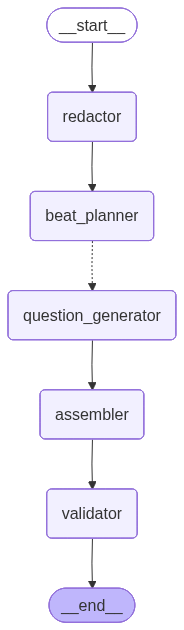

In [11]:

def create_graph():
    builder = StateGraph(PipelineState)

    builder.add_node("redactor", make_redactor_node())
    builder.add_node("beat_planner", beat_planner_node)
    builder.add_node("question_generator", question_generator_worker)
    builder.add_node("assembler", assembler_node)
    builder.add_node("validator", validator_node)

    builder.add_edge(START, "redactor")
    builder.add_edge("redactor", "beat_planner")

    builder.add_edge("question_generator", "assembler")
    builder.add_edge("assembler", "validator")
    builder.add_edge("validator", END)

    graph = builder.compile()
    return graph

graph = create_graph()
display(Image(graph.get_graph(xray=1).draw_mermaid_png()))


In [ ]:
exp1 = {
    "scholarship_name": "Vector scholarships",
    "program_type": "Community Leadership",
    "goal_one_liner": "Machine Learning Workshop hosts for academic engagement.",
    "resume_points": [
        "Led a team of 5 in developing a 3D CNN to decode emotional state from 7tfMRI brain images, improved the test accuracy to 80%."
        "Organized and hosted weekly study paper reading groups for over 15 students in transformers.",
        "Conducted research under Prof Geoffery Hinton, resulting in a published paper in a Neurlps 2025 conference.",
    ],
}

user_input = UserInput.model_validate(exp1)
out = graph.invoke({"user_input": user_input})

In [ ]:
out.get("final_questions_by_beat")

{'A': [QuestionObject(beat='A', question='How does your experience with leading a team in developing a 3D CNN align with the goals of the Vector scholarships?', intent='Tests alignment of specific skills with scholarship goals'),
  QuestionObject(beat='A', question='In what ways does hosting study paper reading groups for transformers prepare you for the Community Leadership aspect of the program?', intent="Validates relevance of past experiences to program's leadership focus")],
 'B': [QuestionObject(beat='B', question='How did you improve the test accuracy to 80% in the 3D CNN project?', intent='Tests evidence of technical excellence and problem-solving in Machine Learning.'),
  QuestionObject(beat='B', question='What specific contributions did you make to the published paper under Prof <NAME>?', intent='Validates individual excellence and research impact in academic publishing.')],
 'C': [QuestionObject(beat='C', question='How will the Machine Learning Workshop engage the academic c